<a href="https://colab.research.google.com/github/Maryam1031/Sentiment-Analysis-on-IMDB-Reviews/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow
!pip install scikit-learn


In [ ]:
import pandas as pd

# Path to IMDB dataset on your Google Drive (adjust this)
imdb_file_path = '/content/drive/MyDrive/NLP1/IMDB/IMDB_Dataset.csv'

# Load IMDB dataset
imdb_df = pd.read_csv(imdb_file_path)

# Display the first few rows to inspect
imdb_df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Define the emotion classes
emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

def load_emotion_data(file_path):
    texts = []
    labels = []

    # Open the file and read line by line
    with open(file_path, 'r') as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip()  # Remove extra spaces
            if ';' in line:
                line = line.replace(';', ',')  # Replace semicolons with commas

            parts = line.split(',')

            # Ensure there are exactly two parts: text and emotion label
            if len(parts) == 2:
                text = parts[0].strip()  # Text content
                label = parts[1].strip()  # Emotion label

                # Only include valid emotions
                if label in emotions:
                    texts.append(text)
                    labels.append(emotions.index(label))  # Map label to index
                else:
                    print(f"Skipping line: {line} - Invalid emotion label.")
            else:
                print(f"Skipping line: {line} - Could not extract emotion label.")

    return texts, labels

# Path to the emotion dataset
train_file = '/content/drive/MyDrive/NLP1/Emotions/train.txt'
val_file = '/content/drive/MyDrive/NLP1/Emotions/val.txt'
test_file = '/content/drive/MyDrive/NLP1/Emotions/test.txt'

train_texts, train_labels = load_emotion_data(train_file)
val_texts, val_labels = load_emotion_data(val_file)
test_texts, test_labels = load_emotion_data(test_file)

# Combine all data (train + val + test)
emotion_texts = train_texts + val_texts + test_texts
emotion_labels = train_labels + val_labels + test_labels


In [ ]:
# Combine IMDB and Emotion dataset
# Changed 'text' to 'review' as the column name
imdb_texts = imdb_df['review'].tolist()
imdb_labels = [1 if label == 'positive' else 0 for label in imdb_df['sentiment'].tolist()]

# Combine all texts and labels
texts = imdb_texts + emotion_texts
labels = imdb_labels + emotion_labels

# Initialize tokenizer (using top 5000 most frequent words)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)

# Convert texts to sequences of integers
X = tokenizer.texts_to_sequences(texts)

# Pad sequences to make sure they are all the same length
X = pad_sequences(X, maxlen=100)  # Adjust maxlen as needed

# Convert labels to one-hot encoding (multi-class for emotion, binary for IMDB)
y = to_categorical(labels, num_classes=7)  # For multi-class (IMDB + Emotion)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of training and testing data to verify
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (56000, 100), (56000, 7)
Testing data shape: (14000, 100), (14000, 7)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Clear the session to avoid clutter from previous models
from tensorflow.keras import backend as K
K.clear_session()

# Define the LSTM model with regularization, dropout, batch normalization, and learning rate reduction
model = Sequential()

# Embedding layer to represent words as vectors
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))

# First LSTM layer with L2 regularization
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(BatchNormalization())  # Batch normalization

# Second LSTM layer
model.add(LSTM(128, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(BatchNormalization())  # Batch normalization

# Output layer with softmax activation for multi-class classification
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implement learning rate scheduler to reduce the learning rate if validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model with the learning rate scheduler
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Save the model to Google Drive
model.save('/content/drive/MyDrive/emotion_imdb_model2.h5')


Epoch 1/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.5787 - loss: 2.0057 - val_accuracy: 0.3967 - val_loss: 2.0600 - learning_rate: 0.0010
Epoch 2/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.4174 - loss: 1.1838 - val_accuracy: 0.4496 - val_loss: 0.9785 - learning_rate: 0.0010
Epoch 3/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.5222 - loss: 0.9652 - val_accuracy: 0.7039 - val_loss: 0.7578 - learning_rate: 0.0010
Epoch 4/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.7230 - loss: 0.7366 - val_accuracy: 0.6424 - val_loss: 0.8348 - learning_rate: 0.0010
Epoch 5/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.7278 - loss: 0.8016 - val_accuracy: 0.7057 - val_loss: 0.8053 - learning_rate: 0.0010
Epoch 6/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7592 - loss: 0.7015 - val_accuracy: 0.7724 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 7/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accura

Test Loss: 0.6132068037986755
Test Accuracy: 0.8064285516738892


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8103 - loss: 0.5963
Test Loss: 0.6132068037986755
Test Accuracy: 0.8064285516738892


In [ ]:
# Save the model to Google Drive
model.save('/content/drive/MyDrive/emotion_imdb_model.h5')


In [ ]:
def predict_emotion_or_sentiment(text, model, tokenizer):
    # Tokenize the text
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100)

    # Predict the emotion or sentiment
    pred = model.predict(padded)
    emotion_idx = pred.argmax(axis=-1)[0]

    # Map the predicted index to the emotion or sentiment label
    return emotions[emotion_idx] if emotion_idx < len(emotions) else 'positive' if emotion_idx == 6 else 'negative'

# Example usage
new_text = " but at the same time i'm bored! and i am sad"
predicted_label = predict_emotion_or_sentiment(new_text, model, tokenizer)
print(f"Predicted Emotion or Sentiment: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Predicted Emotion or Sentiment: anger


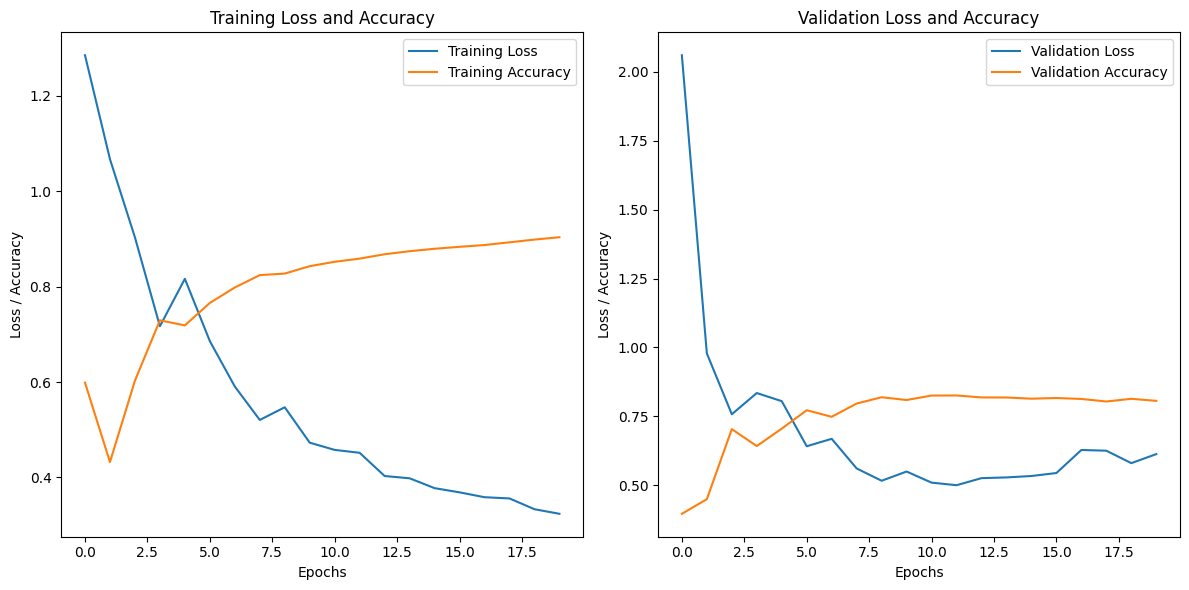

In [ ]:
import matplotlib.pyplot as plt

# Extract the loss and accuracy data from the training history
history_dict = history.history

# Plotting the loss and accuracy
plt.figure(figsize=(12, 6))

# Loss and Accuracy plot (Training Loss and Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()

# Validation Loss and Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
